In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
import re
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Set Parameters
DATA_ROOT = '/home/shawn103/brain_MRI_segmenation_tutorial/kaggle_3m'
im_width = 256
im_height = 256

In [3]:
train_files = []
mask_files = []

pattern = os.path.join(DATA_ROOT,'T*')
folders = sorted(glob(pattern))
for curr_folder in folders:
    curr_pattern = os.path.join(curr_folder,'*_mask*')
    curr_files = glob(curr_pattern)
    curr_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    mask_files.extend(curr_files)

for i in mask_files:
    train_files.append(i.replace('_mask',''))

from pathlib import Path

def positive_negative_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return 1 if value > 0 else 0
    
positives = []
IDs = []

for curr_mask_path in mask_files:
    positives.append(positive_negative_diagnosis(curr_mask_path))
    IDs.append(Path(curr_mask_path).parent.name)
    
df = pd.DataFrame(data={"ID": IDs, "filename": train_files, 'mask_path' : mask_files,'diagnosis': positives})

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size = 0.1,random_state = 101)
df_train, df_val = train_test_split(df_train,test_size = 0.2,random_state = 101)
print('df_train.shape',df_train.values.shape)
print('df_val.shape',df_val.values.shape)
print('df_test.shape',df_test.values.shape)
df_train
# df_test

df_train.shape (2828, 4)
df_val.shape (708, 4)
df_test.shape (393, 4)


,ID,filename,mask_path,diagnosis
206,TCGA_CS_6188_20010812,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
2853,TCGA_FG_A60K_20040224,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
2773,TCGA_FG_A4MT_20020212,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
136,TCGA_CS_5396_20010302,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,1
3888,TCGA_HT_A61B_19991127,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,1
...,...,...,...,...
3470,TCGA_HT_7882_19970125,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,1
2352,TCGA_FG_6688_20020215,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
628,TCGA_DU_5872_19950223,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
1998,TCGA_DU_A5TP_19970614,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0


In [5]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1,
        shuffle=True):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        shuffle = shuffle)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        shuffle = shuffle)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [6]:
def unet1(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), padding='same', name= 'c1_1')(inputs)
    conv1 = BatchNormalization(axis=3, name= 'c1_1_B')(conv1)
    conv1 = Activation('relu', name= 'c1_1_r')(conv1)

    conv1 = Conv2D(32, (3, 3), padding='same', name= 'c1_2')(conv1)
    conv1 = BatchNormalization(axis=3, name= 'c1_2_B')(conv1)
    conv1 = Activation('relu', name= 'c1_2_r')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2), name= 'c1_2_M')(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same', name= 'c2_1')(pool1)
    conv2 = BatchNormalization(axis=3, name= 'c2_1_B')(conv2)
    conv2 = Activation('relu', name= 'c2_1_r')(conv2)

    conv2 = Conv2D(64, (3, 3), padding='same', name= 'c2_2')(conv2)
    conv2 = BatchNormalization(axis=3, name= 'c2_2_B')(conv2)
    conv2 = Activation('relu', name= 'c2_2_r')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2), name= 'c2_2_M')(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same', name= 'c3_1')(pool2)
    conv3 = BatchNormalization(axis=3, name= 'c3_1_B')(conv3)
    conv3 = Activation('relu', name= 'c3_1_r')(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same', name= 'c3_2')(conv3)
    conv3 = BatchNormalization(axis=3, name= 'c3_2_B')(conv3)
    conv3 = Activation('relu', name= 'c3_2_r')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2), name= 'c3_2_M')(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same', name= 'c4_1')(pool3)
    conv4 = BatchNormalization(axis=3, name= 'c4_1_B')(conv4)
    conv4 = Activation('relu', name= 'c4_1_r')(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same', name= 'c4_2')(conv4)
    conv4 = BatchNormalization(axis=3, name= 'c4_2_B')(conv4)
    conv4 = Activation('relu', name= 'c4_2_r')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2), name= 'c4_2_M')(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', name= 'c5_1')(pool4)
    conv5 = BatchNormalization(axis=3, name= 'c5_1_B')(conv5)
    conv5 = Activation('relu', name= 'c5_1_r')(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same', name= 'c5_2')(conv5)
    conv5 = BatchNormalization(axis=3, name= 'c5_2_B')(conv5)
    conv5 = Activation('relu', name= 'c5_2_r')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name= 'ct6')(conv5)
    up6 = concatenate([up6, conv4], axis=3, name= 'ct6_concat_c4_2_r')

    conv6 = Conv2D(256, (3, 3), padding='same', name= 'c6_1')(up6)
    conv6 = BatchNormalization(axis=3, name= 'c6_1_B')(conv6)
    conv6 = Activation('relu', name= 'c6_1_r')(conv6)

    conv6 = Conv2D(256, (3, 3), padding='same', name= 'c6_2')(conv6)
    conv6 = BatchNormalization(axis=3, name= 'c6_2_B')(conv6)
    conv6 = Activation('relu', name= 'c6_2_r')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name= 'ct7')(conv6)
    up7 = concatenate([up7, conv3], axis=3, name= 'ct7_concat_c3_2_r')

    conv7 = Conv2D(128, (3, 3), padding='same', name= 'c7_1')(up7)
    conv7 = BatchNormalization(axis=3, name= 'c7_1_B')(conv7)
    conv7 = Activation('relu', name= 'c7_1_r')(conv7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name= 'c7_2')(conv7)
    conv7 = BatchNormalization(axis=3, name= 'c7_2_B')(conv7)
    conv7 = Activation('relu', name= 'c7_2_r')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name= 'ct8')(conv7)
    up8 = concatenate([up8, conv2], axis=3, name= 'ct8_concat_c2_2_r')

    conv8 = Conv2D(64, (3, 3), padding='same', name= 'c8_1')(up8)
    conv8 = BatchNormalization(axis=3, name= 'c8_1_B')(conv8)
    conv8 = Activation('relu', name= 'c8_1_r')(conv8)

    conv8 = Conv2D(64, (3, 3), padding='same', name= 'c8_2')(conv8)
    conv8 = BatchNormalization(axis=3, name= 'c8_2_B')(conv8)
    conv8 = Activation('relu', name= 'c8_2_r')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name= 'ct9')(conv8)
    up9 = concatenate([up9, conv1], axis=3, name= 'ct9_concat_c1_2_r')

    conv9 = Conv2D(32, (3, 3), padding='same', name= 'c9_1')(up9)
    conv9 = BatchNormalization(axis=3, name= 'c9_1_B')(conv9)
    conv9 = Activation('relu', name= 'c9_1_r')(conv9)

    conv9 = Conv2D(32, (3, 3), padding='same', name= 'c9_2')(conv9)
    conv9 = BatchNormalization(axis=3, name= 'c9_2_B')(conv9)
    conv9 = Activation('relu', name= 'c9_2_r')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name= 'c10_sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10], name='unet1')

In [7]:
def unet2(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same', name='c1_1')(inputs)
    bn1 = Activation('relu', name='c1_1_r')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same', name='c1_2')(bn1)
    bn1 = BatchNormalization(axis=3, name='c1_2_B')(conv1)
    bn1 = Activation('relu', name='c1_2_r')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='c1_2_M')(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same', name='c2_1')(pool1)
    bn2 = Activation('relu', name='c2_1_r')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same', name='c2_2')(bn2)
    bn2 = BatchNormalization(axis=3, name='c2_2_B')(conv2)
    bn2 = Activation('relu', name='c2_2_r')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='c2_2_M')(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same', name='c3_1')(pool2)
    bn3 = Activation('relu', name='c3_1_r')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same', name='c3_2')(bn3)
    bn3 = BatchNormalization(axis=3, name='c3_2_B')(conv3)
    bn3 = Activation('relu', name='c3_2_r')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='c3_2_M')(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same', name='c4_1')(pool3)
    bn4 = Activation('relu', name='c4_1_r')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same', name='c4_2')(bn4)
    bn4 = BatchNormalization(axis=3, name='c4_2_B')(conv4)
    bn4 = Activation('relu', name='c4_2_r')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='c4_2_M')(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same', name='c5_1')(pool4)
    bn5 = Activation('relu', name='c5_1_r')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same', name='c5_2')(bn5)
    bn5 = BatchNormalization(axis=3, name='c5_2_B')(conv5)
    bn5 = Activation('relu', name='c5_2_r')(bn5)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='ct6')(bn5)
    up6 = concatenate([up6, conv4], axis=3, name='ct6_concate_c4_2')
    conv6 = Conv2D(512, (3, 3), padding='same', name='c6_1')(up6)
    bn6 = Activation('relu', name='c6_1_r')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same', name='c6_2')(bn6)
    bn6 = BatchNormalization(axis=3, name='c6_2_B')(conv6)
    bn6 = Activation('relu', name='c6_2_r')(bn6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='ct7')(bn6)
    up7 = concatenate([up7, conv3], axis=3, name='ct7_concate_c3_2')
    conv7 = Conv2D(256, (3, 3), padding='same', name='c7_1')(up7)
    bn7 = Activation('relu', name='c7_1_r')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same', name='c7_2')(bn7)
    bn7 = BatchNormalization(axis=3, name='c7_2_B')(conv7)
    bn7 = Activation('relu', name='c7_2_r')(bn7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='ct8')(bn7)
    up8 = concatenate([up8, conv2], axis=3, name='ct8_concate_c2_2')
    conv8 = Conv2D(128, (3, 3), padding='same', name='c8_1')(up8)
    bn8 = Activation('relu', name='c8_1_r')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same', name='c8_2')(bn8)
    bn8 = BatchNormalization(axis=3, name='c8_2_B')(conv8)
    bn8 = Activation('relu', name='c8_2_r')(bn8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='ct9')(bn8)
    up9 = concatenate([up9, conv1], axis=3, name='ct9_concate_c2_2')
    conv9 = Conv2D(64, (3, 3), padding='same', name='c9_1')(up9)
    bn9 = Activation('relu', name='c9_1_r')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same', name='c9_2')(bn9)
    bn9 = BatchNormalization(axis=3, name='c9_2_B')(conv9)
    bn9 = Activation('relu', name='c9_2_r')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name= 'c10_sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10], name='unet2')

In [8]:
model = unet1(input_size=(im_height, im_width, 3))
# model = unet2(input_size=(im_height, im_width, 3))
print('Use model:',model.name)
print()
model.summary()

Use model: unet1

Model: "unet1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
c1_1 (Conv2D)                   (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
c1_1_B (BatchNormalization)     (None, 256, 256, 32) 128         c1_1[0][0]                       
__________________________________________________________________________________________________
c1_1_r (Activation)             (None, 256, 256, 32) 0           c1_1_B[0][0]                     
____________________________________________________________________________

In [9]:
smooth=100

def dice_coef(y_true, y_pred):
#     y_truef=K.flatten(y_true)
#     y_predf=K.flatten(y_pred)
    And=K.sum(y_true * y_pred)
    return((2* And + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return 1.0- iou(y_true, y_pred)

In [10]:
EPOCHS = 20
BATCH_SIZE = 16
learning_rate = 1e-4

In [11]:
train_generator_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                train_generator_args,
                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                dict(),
                target_size=(im_height, im_width))
    
decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
callbacks = [ModelCheckpoint('%s_brain_mri_seg_epoch_%d.hdf5'%(model.name,EPOCHS), verbose=0, save_best_only=True)]

# Shut down other kernel before training

In [12]:
history = model.fit(train_gen,
            steps_per_epoch=len(df_train) / BATCH_SIZE, 
            epochs=EPOCHS, 
            callbacks=callbacks,
            validation_data = val_gen,
            validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/20
177/176 [==============================] - ETA: 0s - loss: 0.9372 - binary_accuracy: 0.8759 - iou: 0.0329 - dice_coef: 0.0628Found 708 validated image filenames.
Found 708 validated image filenames.
176/176 [==============================] - 125s 682ms/step - loss: 0.9372 - binary_accuracy: 0.8759 - iou: 0.0329 - dice_coef: 0.0628 - val_loss: 0.9801 - val_binary_accuracy: 0.0480 - val_iou: 0.0103 - val_dice_coef: 0.0202
Epoch 2/20
176/176 [==============================] - 43s 244ms/step - loss: 0.8982 - binary_accuracy: 0.9706 - iou: 0.0545 - dice_coef: 0.1018 - val_loss: 0.9438 - val_binary_accuracy: 0.9849 - val_iou: 0.0292 - val_dice_coef: 0.0558
Epoch 3/20
176/176 [==============================] - 51s 290ms/step - loss: 0.8657 - binary_accuracy: 0.9784 - iou: 0.0734 - dice_coef: 0.1344 - val_loss: 0.8758 - val_binary_accuracy: 0.9677 - val_iou: 0.0663 - val_dice_coef: 0.1225
Epoch 4/20
122/176 

KeyboardInterrupt: 

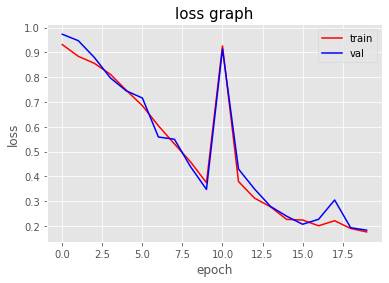

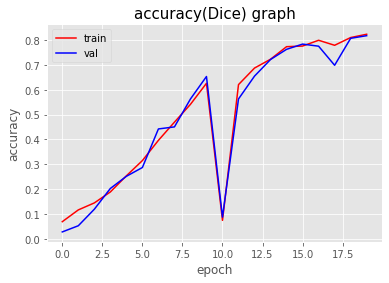

In [13]:
train_log = history.history

list_traindice = train_log['dice_coef']
list_testdice = train_log['val_dice_coef']

list_trainjaccard = train_log['iou']
list_testjaccard = train_log['val_iou']

list_trainloss = train_log['loss']
list_testloss = train_log['val_loss']
plt.figure(1)
plt.plot(list_trainloss,'r-',label='train')
plt.plot(list_testloss, 'b-',label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('loss graph', fontsize = 15)

plt.figure(2)
plt.plot(list_traindice, 'r-',label='train')
plt.plot(list_testdice, 'b-',label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy(Dice) graph', fontsize = 15)
plt.show()

In [14]:
model = load_model('%s_brain_mri_seg_epoch_%d.hdf5'%(model.name, EPOCHS),
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [15]:
test_gen = train_generator(df_test, BATCH_SIZE,
                dict(),
                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test binary_accuracy: ",results[1])
print("Test iou: ",results[2])
print("Test Dice Coefficent: ",results[3])

## Record the result as file
df = pd.DataFrame([results],columns=['loss','binary_accuracy','iou','Dice Coefficent'])
record_file_path = './%s_test_result_epoch_%d.csv'%(model.name, EPOCHS)
df.to_csv(record_file_path,index=False)
print('Save record:',record_file_path)


Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 8s 309ms/step - loss: 0.1689 - binary_accuracy: 0.9973 - iou: 0.7200 - dice_coef: 0.8312
Test loss:  0.1688556969165802
Test binary_accuracy:  0.9972906708717346
Test iou:  0.7199670076370239
Test Dice Coefficent:  0.8311639428138733
Save record: ./unet1_test_result_epoch_20.csv


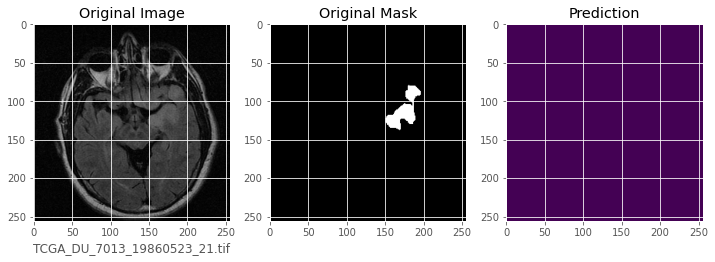

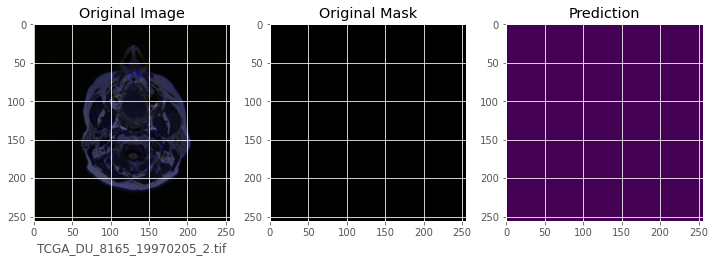

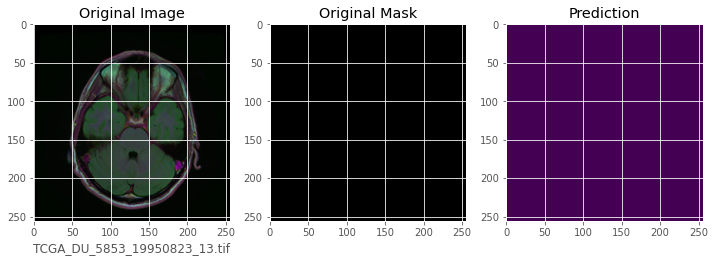

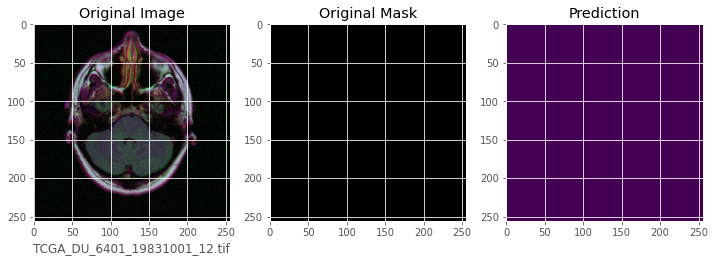

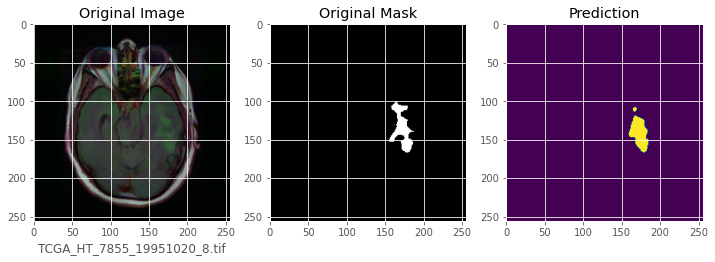

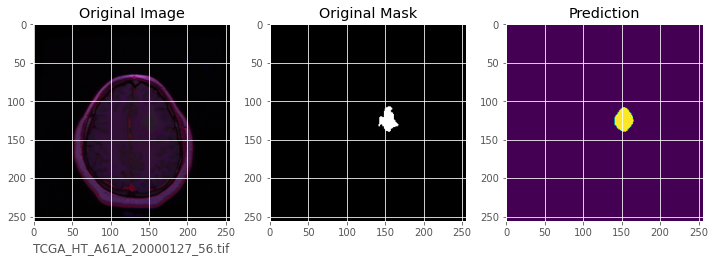

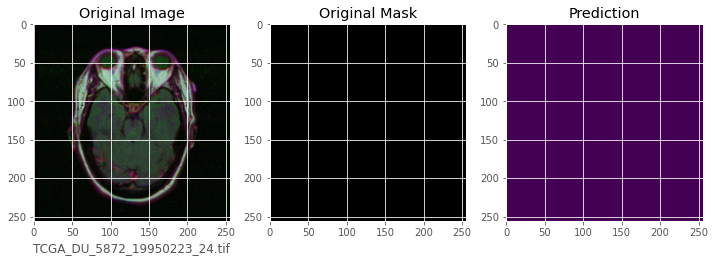

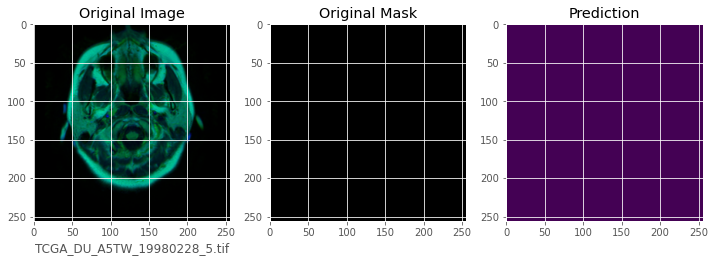

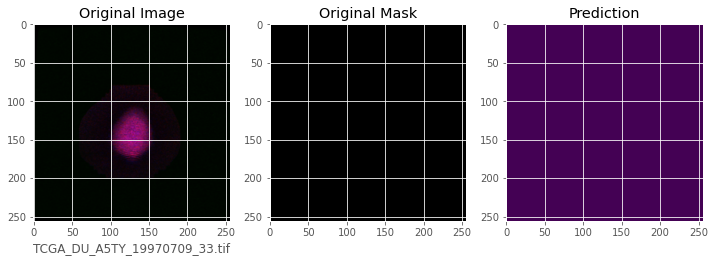

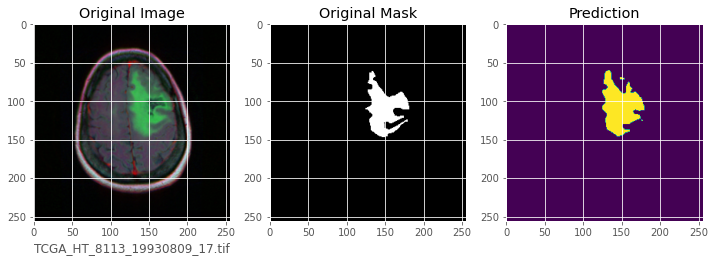

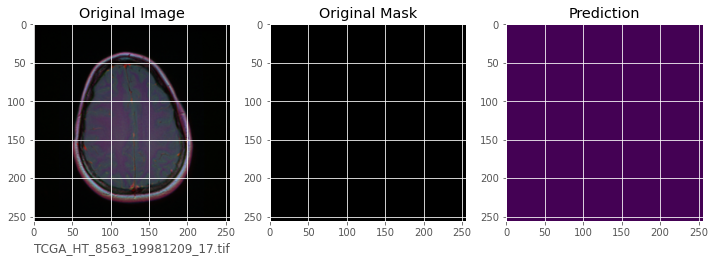

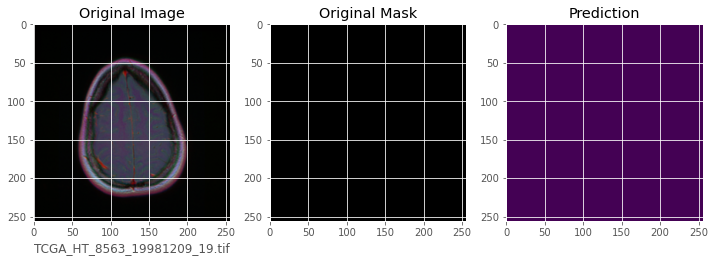

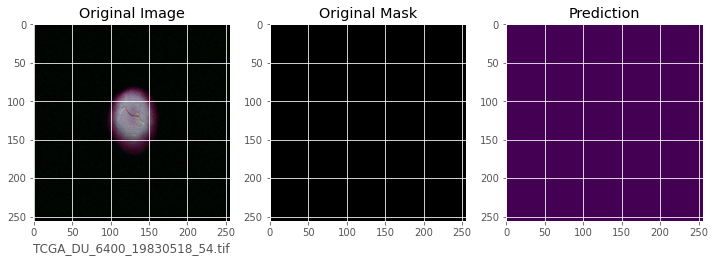

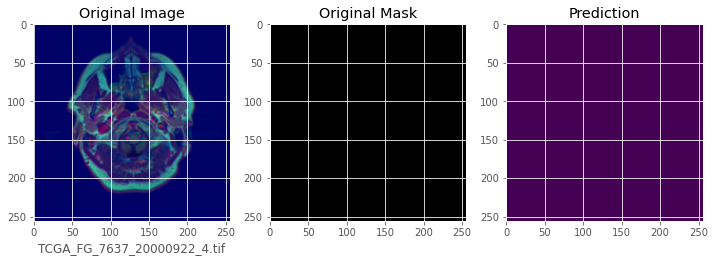

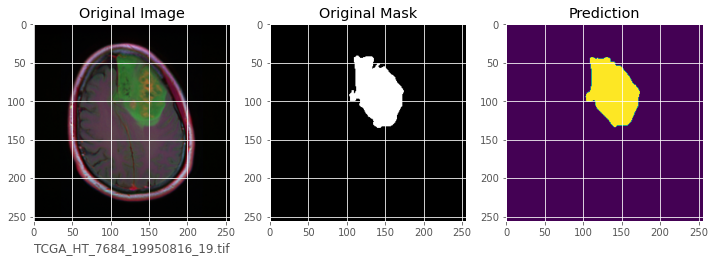

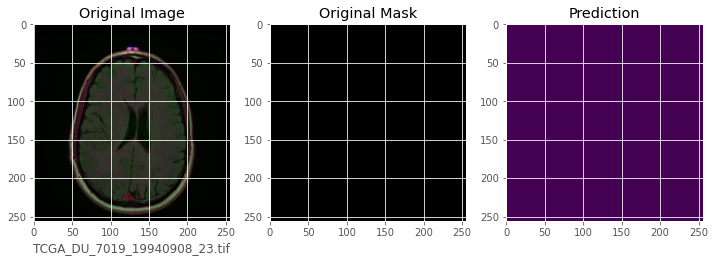

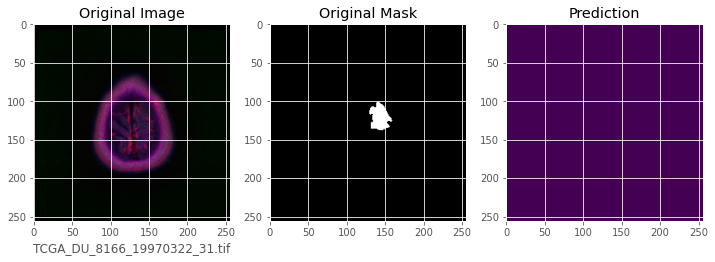

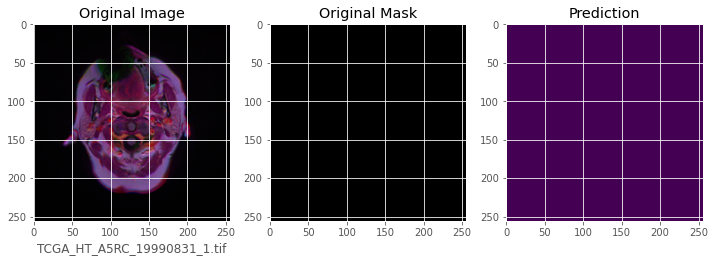

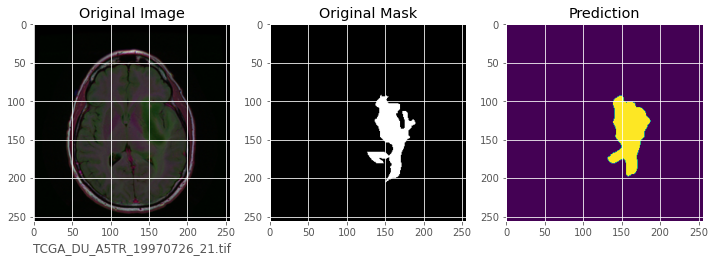

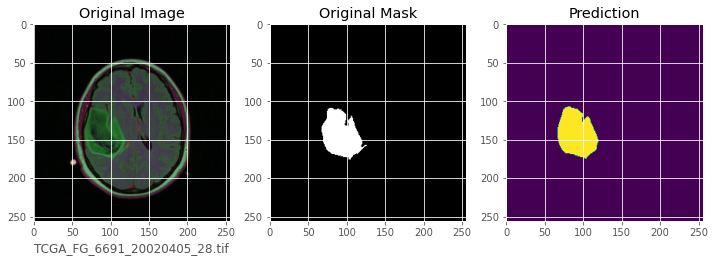

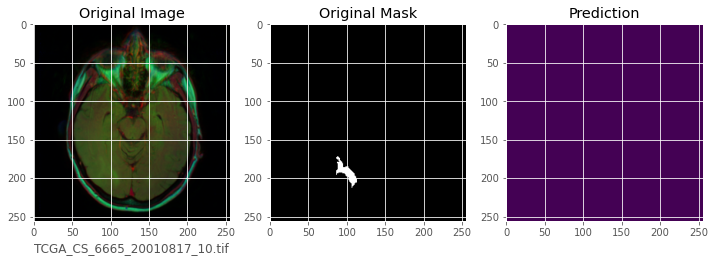

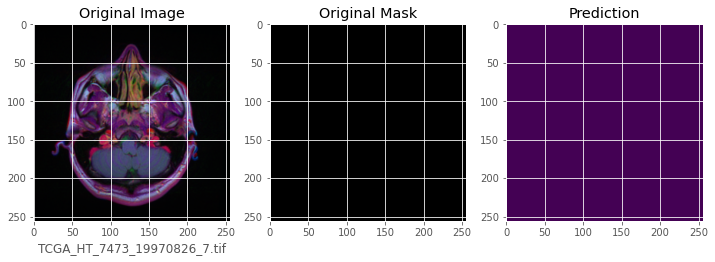

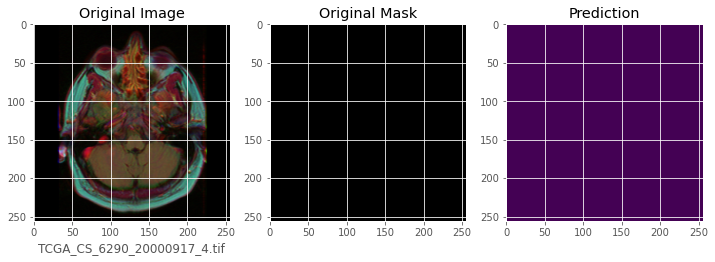

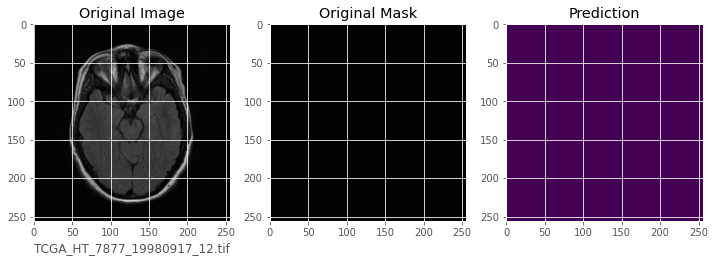

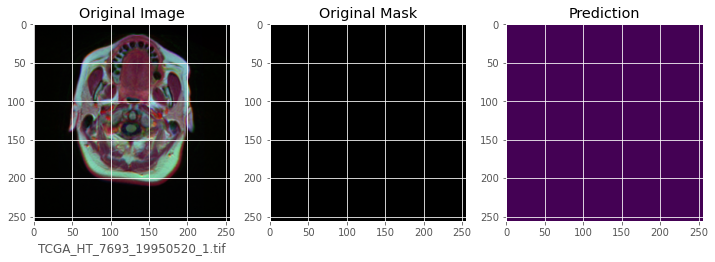

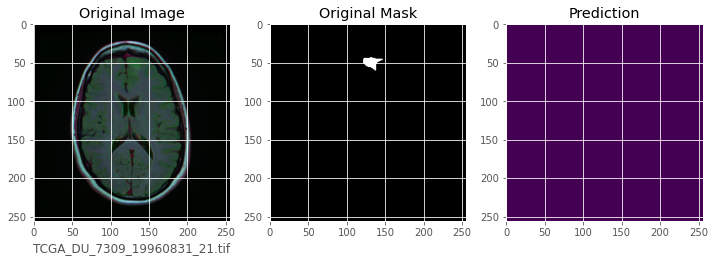

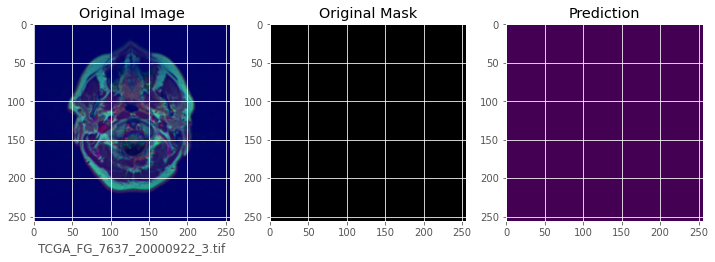

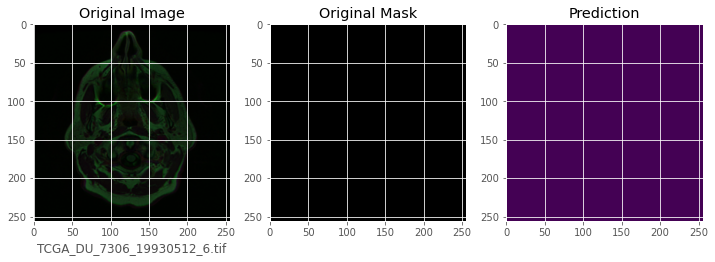

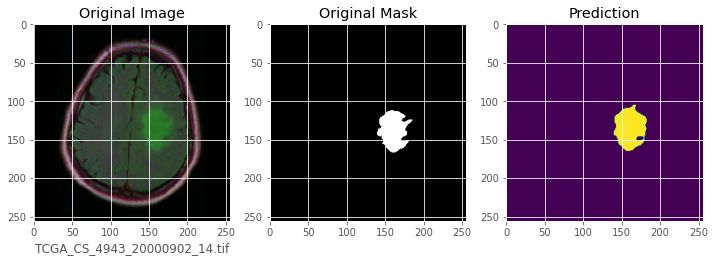

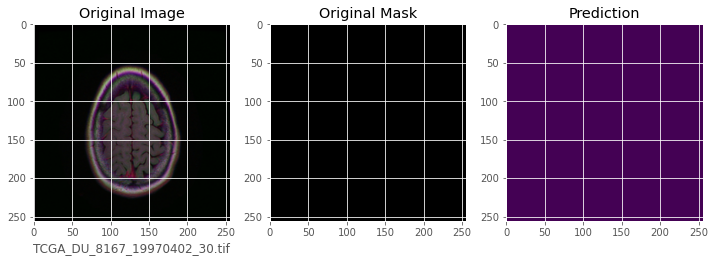

In [27]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img_path = df_test['filename'].iloc[index]
    img = cv2.imread(img_path)
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    curr_ax = plt.subplot(1,3,1)
    curr_ax.set_xlabel(os.path.basename(img_path))
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()